# Correlation analysis for IFN-B response

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy
from matplotlib.colors import ListedColormap

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/schypo-0.0.0-py3.7.egg')
import schypo

In [9]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [10]:
tf = 'STAT1'

### Load the data

In [11]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [12]:
def simplify_name(name):
    return name.split('.')[0]

In [13]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


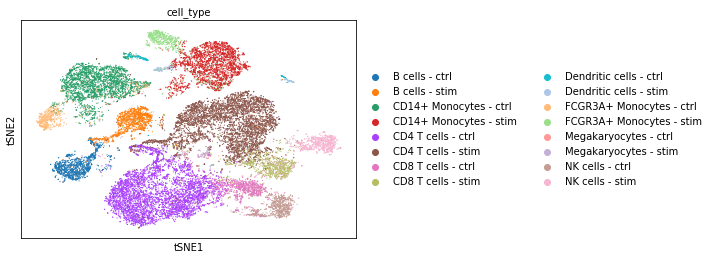

In [14]:
sc.pl.tsne(adata, color='cell_type')

In [15]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [16]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [17]:
# with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
# 	tfs = pkl.load(f)

In [18]:
# tf_df = pd.read_csv('attribute_list_entries.txt', sep='\t')
# tfs = tf_df['GeneSym'].tolist()

In [19]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

In [20]:
distances = pd.read_csv(data_path + 'chipseq/union/intersect_distances.csv').rename(columns={'gene_name':'gene'})
isgf3_genes = distances.query('distance == 0').gene.tolist()

### Function for getting mean correlations

In [486]:
def compute_mean_correlation(tf, thresh=0.0, perc=0.7, ct='CD14+ Monocytes', return_genes=False):
    
    adata_ct =  adata[adata.obs.cell == ct].copy()

    schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

    schypo.compute_1d_moments(
        adata_ct, inplace=True, filter_genes=True, 
        residual_var=True,filter_mean_thresh=thresh, 
        min_perc_group=perc)

    target_genes = adata_ct.var.index.tolist()
    filtered_tfs = list(set(target_genes) & set(tfs))
        
    if return_genes:
        return target_genes
    schypo.compute_2d_moments(
        adata_ct, list(itertools.product([tf], target_genes)))

    
    
    ctrl_mean_corr = 0
    stim_mean_corr = 0

    ctrl_count = 0
    stim_count = 0

    for group in adata_ct.uns['schypo']['groups']:

        temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
        temp[(temp > 1) | (temp < -1)] = np.nan
        temp[np.isnan(temp)] = 0

        if 'ctrl' in group:
            ctrl_mean_corr += temp
            ctrl_count += ~np.isnan(temp)

        if 'stim' in group:
            stim_mean_corr += temp
            stim_count += ~np.isnan(temp)

    ctrl_mean_corr /= ctrl_count
    stim_mean_corr /= stim_count

    del ctrl_count, stim_count
    
    return ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs
    # df['corr']  = df['corr'].abs()

### STAT1/STAT2 correlations

In [522]:
tf = 'STAT1'
high_genes = compute_mean_correlation(tf, thresh=0.05, perc=0.7, ct='CD14+ Monocytes', return_genes=True)

In [526]:
def plot_isgf3_bar(ct):
    
    tf = 'STAT1'

    ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(tf, thresh=0.01, perc=0.85, ct=ct)
    
    ctrl_df = pd.DataFrame()
    ctrl_df['gene'] = target_genes
    ctrl_df['corr'] = ctrl_mean_corr.ravel()
    ctrl_df['stim'] = 'ctrl'
    ctrl_df['isgf3'] = ctrl_df['gene'].apply(lambda x: x in isgf3_genes)
    ctrl_df['high_exp'] = ctrl_df['gene'].apply(lambda x: x in high_genes)
    ctrl_df = ctrl_df.query('high_exp')

    stim_df = pd.DataFrame()
    stim_df['gene'] = target_genes
    stim_df['corr'] = stim_mean_corr.ravel()
    stim_df['stim'] = 'stim'
    stim_df['isgf3'] = stim_df['gene'].apply(lambda x: x in isgf3_genes)
    stim_df['high_exp'] = stim_df['gene'].apply(lambda x: x in high_genes)
    stim_df = stim_df.query('high_exp')

    df = pd.concat([ctrl_df, stim_df])
    
    
    print('ctrl',stats.mannwhitneyu(ctrl_df.query('isgf3')['corr'], ctrl_df.query('~isgf3')['corr']))
    print('stim',stats.mannwhitneyu(stim_df.query('isgf3')['corr'], stim_df.query('~isgf3')['corr']))
    sns.boxplot(x='stim', y='corr', hue='isgf3', data=df, fliersize=1)
    plt.ylim(-0.4, 0.4)
    plt.legend('', frameon=False)
    
    return df

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


ctrl MannwhitneyuResult(statistic=159995.0, pvalue=4.2196487369059214e-05)
stim MannwhitneyuResult(statistic=167234.0, pvalue=0.0011416665262346146)


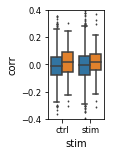

In [527]:
plt.figure(figsize=(1, 2))
df = plot_isgf3_bar('CD14+ Monocytes')

### Ctrl vs stim distributions

In [57]:
def nan_distplot(x):
    
    sns.distplot(x[~np.isnan(x)], hist=False)

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


HIF1A MannwhitneyuResult(statistic=844416.0, pvalue=2.12411592031829e-14)


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


IRF7 MannwhitneyuResult(statistic=915638.0, pvalue=8.66111024343511e-06)


Text(0.5, 0, 'correlation')

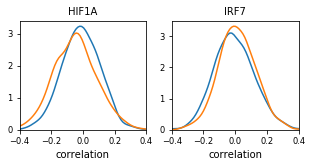

In [692]:
plt.figure(figsize=(5, 2));
plt.subplot(1, 2, 1);

tf = 'HIF1A'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.85)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel())
nan_distplot(stim_mean_corr.ravel())
plt.xlim(-0.4, 0.4)
plt.title(tf)
plt.xlabel('correlation')

plt.subplot(1, 2, 2);
tf = 'IRF7'
ctrl_mean_corr, stim_mean_corr, target_genes, filtered_tfs = compute_mean_correlation(
    tf, thresh=0.07, perc=0.85)
print(tf, stats.mannwhitneyu(ctrl_mean_corr.ravel(), stim_mean_corr.ravel()))
nan_distplot(ctrl_mean_corr.ravel())
nan_distplot(stim_mean_corr.ravel())
plt.xlim(-0.4, 0.4)
plt.title(tf)
plt.xlabel('correlation')

# plt.savefig(fig_path + '{}_{}_corr_shift.pdf'.format('HIF1A', 'IRF7'), bbox_inches='tight')


### DC hits

In [560]:
adata_ct = sc.read(data_path + 'result_2d/mono_ifn/tf.h5ad')

In [561]:
df = schypo.get_2d_ht_result(adata_ct)

In [562]:
ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:
    
    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = np.nan
    temp[np.isnan(temp)] = 0
        
    if 'ctrl' in group:
        ctrl_mean_corr += temp
        ctrl_count += ~np.isnan(temp)
        
    if 'stim' in group:
        stim_mean_corr += temp
        stim_count += ~np.isnan(temp)

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [563]:
df['ctrl'] = ctrl_mean_corr
df['stim'] = stim_mean_corr

df['ctrl_mag'] = np.absolute(ctrl_mean_corr)
df['stim_mag'] = np.absolute(stim_mean_corr)

In [565]:
high_corr_df = df.query('ctrl_mag > 0.25 | stim_mag > 0.25').copy()
high_corr_df['corr_fdr'] = schypo.util._fdrcorrect(high_corr_df['corr_pval'])

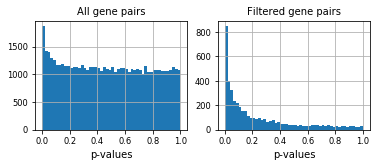

In [679]:
plt.figure(figsize=(6, 2));
plt.subplot(1, 2, 1);
df['corr_pval'].hist(bins=50)
plt.title('All gene pairs')
plt.xlabel('p-values')
plt.subplot(1, 2, 2);
high_corr_df['corr_pval'].hist(bins=50)
plt.title('Filtered gene pairs')
plt.xlabel('p-values')

plt.savefig(fig_path + 'dc_calibration.pdf', bbox_inches='tight')


In [662]:
high_corr_df.query('gene_1 == "JUNB" & corr_fdr < 0.1 & corr_coef > 0').sort_values('stim')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag
1503,JUNB,TMEM167B,0.372797,0.013599,0.089120,-0.272908,-0.070290,0.272908,0.070290
1653,JUNB,SSB,0.282698,0.002800,0.048694,-0.289632,0.054868,0.289632,0.054868
2001,JUNB,ATP5J2,0.367568,0.012799,0.087031,-0.086582,0.251600,0.086582,0.251600
2675,JUNB,ZFAS1,0.219567,0.009399,0.077701,0.074612,0.290435,0.074612,0.290435
2201,JUNB,IRF7,0.215181,0.016998,0.097919,0.044205,0.328360,0.044205,0.328360


### Get correlations for network

In [688]:
edge_df = high_corr_df.query('ctrl_mag > 0.35 | stim_mag > 0.35').query('gene_1 != gene_2').copy()
edge_df['sig'] = edge_df['corr_fdr'] < 0.1
edge_df['TF'] = 1

In [689]:
edge_df.head(5)

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag,sig,TF
99,CREM,MCL1,0.237068,0.135986,0.262342,0.117491,0.401174,0.117491,0.401174,False,1
207,CREM,LINC00152,0.269008,0.051195,0.161777,0.097675,0.437149,0.097675,0.437149,False,1
374,CREM,NDUFC1,0.308532,0.022198,0.111161,-0.365182,-0.040951,0.365182,0.040951,False,1
389,CREM,IL7R,-0.393700,0.000334,0.043357,0.372901,-0.029957,0.372901,0.029957,True,1
427,CREM,SRA1,-0.311985,0.067793,0.181827,0.352930,-0.116153,0.352930,0.116153,False,1


In [693]:
edge_df.query('gene_1 == "IRF7"')

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr,ctrl,stim,ctrl_mag,stim_mag,sig,TF
55476,IRF7,ELOVL1,0.352301,0.015198,0.092875,-0.373106,0.047986,0.373106,0.047986,True,1
55547,IRF7,PFDN2,0.417749,0.004000,0.055994,-0.419801,0.001700,0.419801,0.001700,True,1
55636,IRF7,PLEKHB2,0.287137,0.037596,0.141135,-0.351307,-0.011929,0.351307,0.011929,False,1
55835,IRF7,IRF1,-0.168121,0.191581,0.320981,0.351778,0.122092,0.351778,0.122092,False,1
55948,IRF7,DYNLT1,-0.523740,0.000067,0.039308,0.484368,-0.044873,0.484368,0.044873,True,1
55968,IRF7,TAX1BP1,-0.334575,0.022398,0.111545,0.351984,-0.178781,0.351984,0.178781,False,1
56010,IRF7,TFEC,-0.332534,0.069993,0.185309,0.409548,0.010813,0.409548,0.010813,False,1
56032,IRF7,GK,-0.199350,0.208379,0.338588,0.431717,0.266748,0.431717,0.266748,False,1
56193,IRF7,GLRX3,0.143076,0.295170,0.421725,-0.397158,-0.201541,0.397158,0.201541,False,1
56239,IRF7,TMEM179B,-0.442000,0.023398,0.113641,0.357579,0.012428,0.357579,0.012428,False,1


In [694]:
edge_df.to_csv('filtered_edges.csv', index=False)

### Examples

In [661]:
def get_ind_corr(adata, gene_1, gene_2):
    
    idx = adata.uns['schypo']['2d_moments']['gene_pairs'].index((gene_1, gene_2))
    
    df_list = []
    for group in adata.uns['schypo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata.uns['schypo']['2d_moments'][group]['corr'][idx]))
    return pd.DataFrame(df_list, columns=[ 'ind','stim', 'corr']).query('corr < 1 & corr > -1')


def variability_scatter(X, c, vmin=None, vmax=None, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);
    
    
def plot_microscopy(X, c1, c2, labels, s=5, end_num=-5, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    c1_mean = np.zeros(c1.shape[0])
    c2_mean = np.zeros(c2.shape[0])
    c1_mean[labels] = c1[labels].mean()
    c1_mean[~labels] = c1[~labels].mean()
    c2_mean[labels] = c2[labels].mean()
    c2_mean[~labels] = c2[~labels].mean()
    
    prod = (c1-c1_mean)*(c2-c2_mean)
    
    c1 = np.clip(c1, a_min=0, a_max=np.sort(c1)[end_num])
    c2 = np.clip(c2, a_min=0, a_max=np.sort(c2)[end_num])
    prod = np.clip(prod, a_min=np.sort(prod)[50], a_max=np.sort(prod)[end_num])
    
    print(prod.min(), prod.max())

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    prod = (prod - prod.min())/(prod.max()-prod.min())
    order_1 = np.argsort(c1)
    order_2 = np.argsort(c2)
    order_prod = np.argsort(prod)
    
    print(prod)
    ListedColormap(sns.dark_palette("red", 100).as_hex())
        
    plt.subplot(1, 3, 1); 
        
    plt.scatter(X[order_1, 0], X[order_1, 1], c=c1[order_1], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("red", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_1)
        
    plt.subplot(1, 3, 2); 
    plt.scatter(X[order_2, 0], X[order_2, 1], c=c2[order_2], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("green", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_2)

        
    plt.subplot(1, 3, 3); 
    plt.scatter(X[order_prod, 0], X[order_prod, 1], c=prod[order_prod], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("orange", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    plt.title(gene_1 + ' * ' + gene_2)
    
    return prod
        

norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == 'CD14+ Monocytes'].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata
labels = (norm_adata.obs.stim == 'stim').values

In [659]:
labels.shape

(5341,)

-70.46329308847874 414.3648017994549
[0.10723051 0.14855641 0.1497327  ... 0.13244181 0.15609587 0.1478905 ]


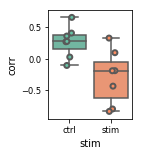

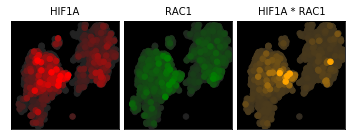

In [670]:
gene_1, gene_2 = 'HIF1A', 'RAC1'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

prods = plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-48.90154270149867 369.8227545498992
[0.12025266 0.09868724 0.12025266 ... 0.1212593  0.         0.14673489]


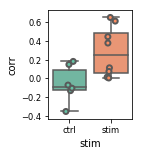

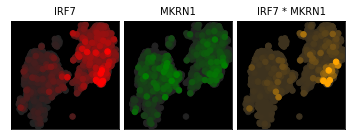

In [669]:
gene_1, gene_2 = 'IRF7', 'MKRN1'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    labels=labels,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')

-164.9709781904519 1255.1077571216601
[0.10889595 0.12344655 0.12980533 ... 0.13386345 0.05654637 0.10109223]


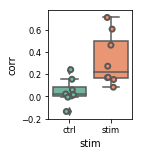

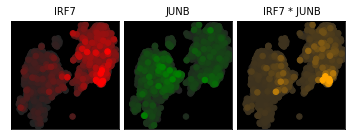

In [668]:
gene_1, gene_2 = 'IRF7', 'JUNB'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-5,
    labels=labels,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')
plt.savefig(fig_path + '{}_{}_scatter.png'.format(gene_1, gene_2), bbox_inches='tight')